In [1]:
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
from qdev_wrappers.dataset.doNd import do0d, do1d, do2d


from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment
from qcodes.dataset.plotting import plot_by_id
import plottr
import qcodes.config
from qcodes.tests.instrument_mocks import DummyChannelInstrument

c:\users\jenielse\source\repos\qdev-wrappers\qdev_wrappers\logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '


# Live plotting

This should perform live plotting automatically provided that you have plottr or qcplot installed and running. Plotter can be found at https://github.com/kouwenhovenlab/plottr and QCPlot in Teams. The live plotting needs to be configured as descried in in https://qcodes.github.io/Qcodes/examples/plotting/live_plotting.html



In [3]:
initialise_database()  # just in case no database file exists
new_experiment("doNd-tutorial", sample_name="no sample")

doNd-tutorial#no sample#15@C:\Users\jenielse\source\repos\qcodes_generate_test_db\qcplotbenchmark.db
----------------------------------------------------------------------------------------------------

In [4]:
# preparatory mocking of physical setup
from qcodes.tests.instrument_mocks import DummyInstrument
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])
channlinstrument = DummyChannelInstrument('arrayinst')

In [5]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [6]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)
dmm.v2.get = np.random.rand

Starting experimental run with id: 38


100%|██████████| 100/100 [00:00<00:00, 689.54it/s]


plot by id took 0.05803966522216797


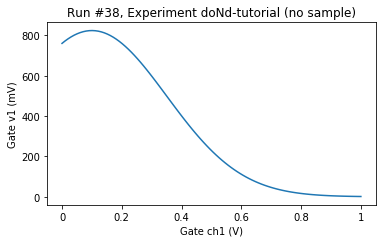

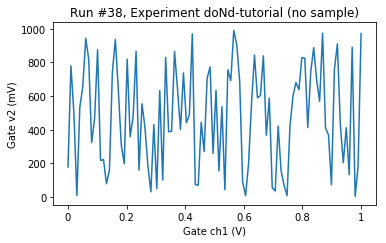

In [7]:
dataid, ax, cbax = do1d(dac.ch1, 0, 1, 100, 0.00001, dmm.v1, dmm.v2)

Starting experimental run with id: 44


100%|██████████| 100/100 [00:00<00:00, 158.73it/s]


plot by id took 0.7440288066864014


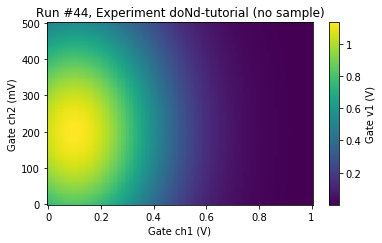

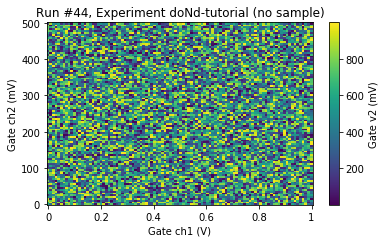

In [13]:
dataid, ax, cbax = do2d(dac.ch1, 0, 1, 100, 0, 
                        dac.ch2, 0, 0.5, 100, 0, 
                        dmm.v1, dmm.v2,
                        do_plot=True)

# Adding some actions

Below we will demonstarte that it's possible to execute actions both before and after each stage on the loops. We will leave these actions as simple prints so that one can see when they are triggered.

In [14]:
def before_action():
    print("called before the loop")

def after_action():
    print("called after the loop")
    
def at_each_action():
    print("called at each step")
    
def before_inner_action():
    print("called before inner loop")
    
def after_inner_action():
    print("called after inner loop")

called before the loop
Starting experimental run with id: 45


  0%|          | 0/10 [00:00<?, ?it/s]

called at each step
called at each step
called at each step
called at each step
called at each step
called at each step
called at each step
called at each step


 80%|████████  | 8/10 [00:00<00:00, 79.19it/s]

called at each step
called at each step


100%|██████████| 10/10 [00:00<00:00, 75.75it/s]


called after the loop
plot by id took 0.0500338077545166


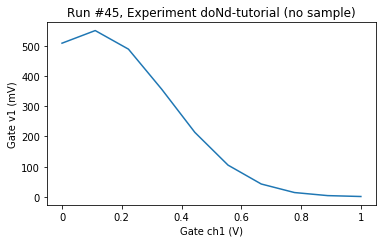

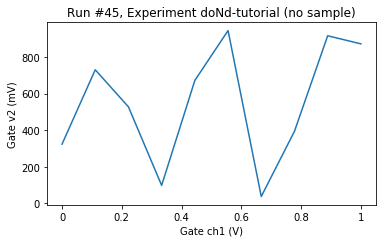

In [15]:
dataid = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2, at_each_action,
              enter_actions=(before_action,), exit_actions=(after_action,))

called before the loop
Starting experimental run with id: 46


  0%|          | 0/3 [00:00<?, ?it/s]

called before inner loop
called at each step
called at each step
called after inner loop
called before inner loop
called at each step
called at each step
called after inner loop
called before inner loop
called at each step
called at each step
called after inner loop


100%|██████████| 3/3 [00:00<00:00, 50.85it/s]


called after the loop
plot by id took 0.07599377632141113


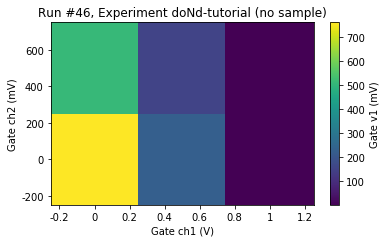

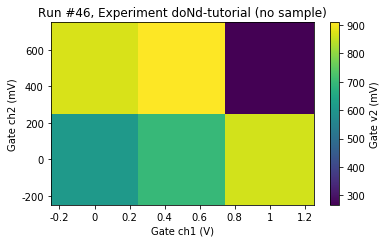

In [16]:
dataid = do2d(dac.ch1, 0, 1, 3, 0.01, 
              dac.ch2, 0, 0.5, 2, 0.01, 
              dmm.v1, dmm.v2, at_each_action,
              before_inner_actions=(before_inner_action,),
              after_inner_actions=(after_inner_action,),
              enter_actions=(before_action,), exit_actions=(after_action,))

# Array and MultiParameters

In [17]:
channlinstrument.A.dummy_array_parameter.get = lambda: np.random.rand(5)

Starting experimental run with id: 47


100%|██████████| 10/10 [00:00<00:00, 93.98it/s]


plot by id took 0.04902243614196777


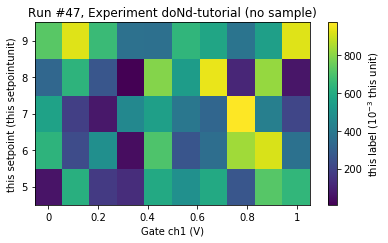

In [18]:
dataid = do1d(dac.ch1, 0, 1, 10, 0.01, channlinstrument.A.dummy_array_parameter)

## do0D

Perhaps we just want to capture the arrayparameter without doing any sweep

dataid = do0d(channlinstrument.A.dummy_array_parameter)

Now lets try capturing 2 Array parameters.
First lets change the setpoints of one of them a bit to make them standout from each other

In [19]:
channlinstrument.B.dummy_array_parameter.setpoints = ((9.0, 10.0, 11.0, 12.0, 13.0),)

Starting experimental run with id: 48
plot by id took 0.05100131034851074


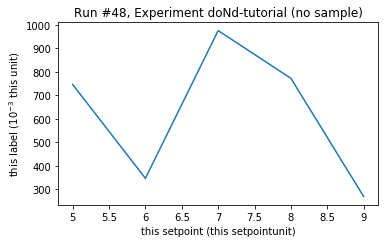

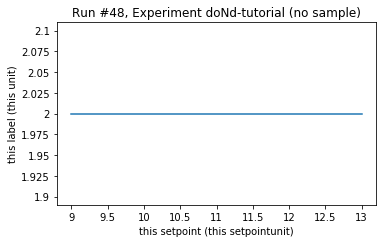

In [20]:
dataid = do0d(channlinstrument.A.dummy_array_parameter, channlinstrument.B.dummy_array_parameter)